### 1. Extract Audio Features
This function, `extract_features`, takes a file path as input and extracts several features from the audio file:
- **MFCCs**: Mel-Frequency Cepstral Coefficients capture spectral characteristics of the audio.
- **Spectral Centroid**: Represents the "center of mass" of the spectrum.
- **Spectral Contrast**: Measures the difference between peaks and valleys in the sound spectrum.
- **Zero-Crossing Rate**: Represents the rate at which the signal changes sign.

The function returns these features as a single concatenated array.

### 2. Load Audio Files and Extract Features
We load audio files from a directory. 

We then split these into two sets to represent:
- **Reference Data**: Audio data used as the baseline.
- **Current Data**: New audio data on which we’ll simulate data drift.


In [38]:
import numpy as np
import pandas as pd
import librosa
import glob

# corrupt audio with noise (simulate data distribution drift)
def add_drift_to_audio(audio_samples, noise_level=0.05):
    return audio_samples + np.random.normal(0, noise_level, audio_samples.shape)

# extract MFCCs and other audio features
def extract_features(y, sr, n_mfcc=4):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()
    return np.concatenate([mfccs.mean(axis=1), [spectral_centroid, spectral_contrast, zero_crossing_rate]])
    # concatenate all features
    # return np.array([spectral_centroid, spectral_contrast, zero_crossing_rate])

# Get file paths for audio files (only for demonstration purposes we use the one subset of a dataset)
file_paths = glob.glob("../data/nort3160/common_voice_17_0/da/da/audio/test/*.mp3")
# ../data/nort3160/ravnursson/fo/fo/audio/test/*.flac.wav

# take only 10 files for demonstration purposes
file_paths = file_paths[:10]
split_index = len(file_paths) // 2

reference_files = file_paths[:split_index]
current_files = file_paths[split_index:]

print(len(reference_files), len(current_files))

# extract features for reference data (original audio)
n_mfcc = 4
reference_data = []
for file in reference_files:
    y, sr = librosa.load(file)
    features = extract_features(y, sr, n_mfcc=n_mfcc)
    reference_data.append(features)
reference_data = pd.DataFrame(reference_data)


5 5


## Simulate Data Drift
To simulate data drift, we’ll introduce noise to the current data to mimic real-world scenarios where audio data might degrade over time. 

In this example, we'll add random Gaussian noise to each feature in the `current_data` DataFrame.


In [ ]:
current_data = []
current_data_drifted = []
noise_level = 0.2
y_original = sr_original = y_drifted = sr_drifted = None

for idx, file in enumerate(current_files):
    y, sr = librosa.load(file)
    original_features = extract_features(y, sr)
    current_data.append(original_features)
    
    # add noise to create drifted audio, then extract features
    drifted_y = add_drift_to_audio(y, noise_level=noise_level)
    drifted_features = extract_features(drifted_y, sr)
    current_data_drifted.append(drifted_features)

    if idx == 0:
        # save the first for demonstration purposes
        y_original, sr_original = y, sr
        y_drifted, sr_drifted = drifted_y, sr

current_data = pd.DataFrame(current_data)
current_data_drifted = pd.DataFrame(current_data_drifted)

# rename columns to match the feature names (for evidently ai)
feature_columns = [f'mfcc_{i}' for i in range(n_mfcc)] + ['spectral_centroid', 'spectral_contrast', 'zero_crossing_rate']
reference_data.columns = feature_columns
current_data_drifted.columns = feature_columns

# print("Reference Data:\n", reference_data.head())
# print("Current Data:\n", current_data.head())
# print("Current Data (Drifted):\n", current_data_drifted.head())


### plot a sample data so see and hear the differences

In [40]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display

def plot_waveform_and_spectrogram(audio, sr, title):
    plt.figure(figsize=(12, 6))

    # waveform
    plt.subplot(2, 1, 1)
    plt.plot(audio, color='gray')
    plt.title(f"{title} - Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    # spectrogram
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title} - Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

Original Audio:


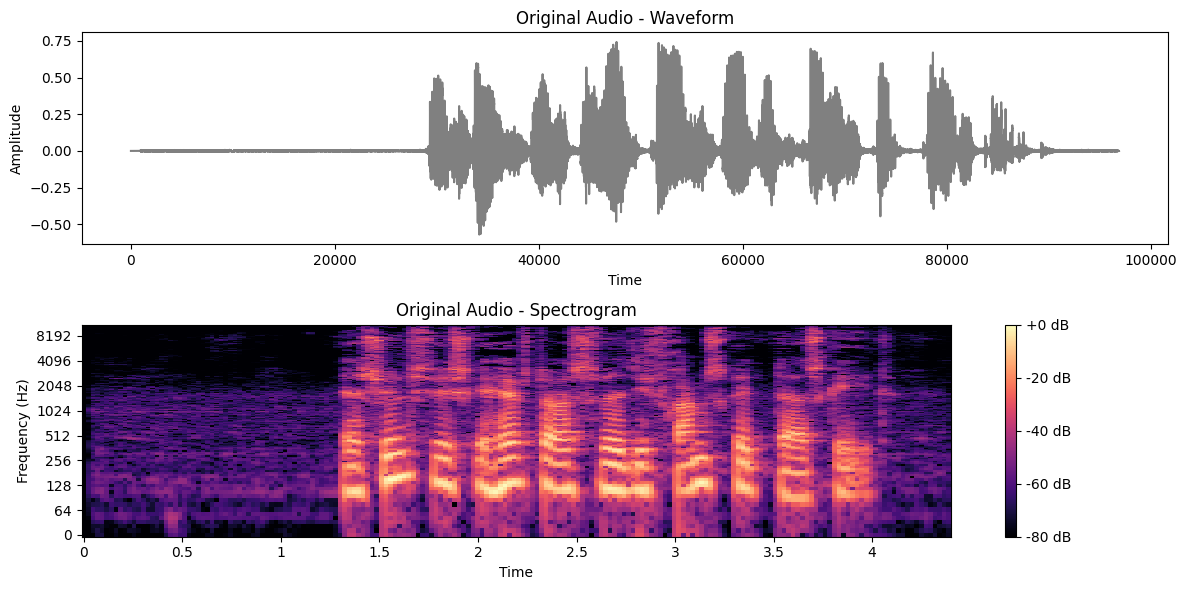

Drifted Audio with Noise:


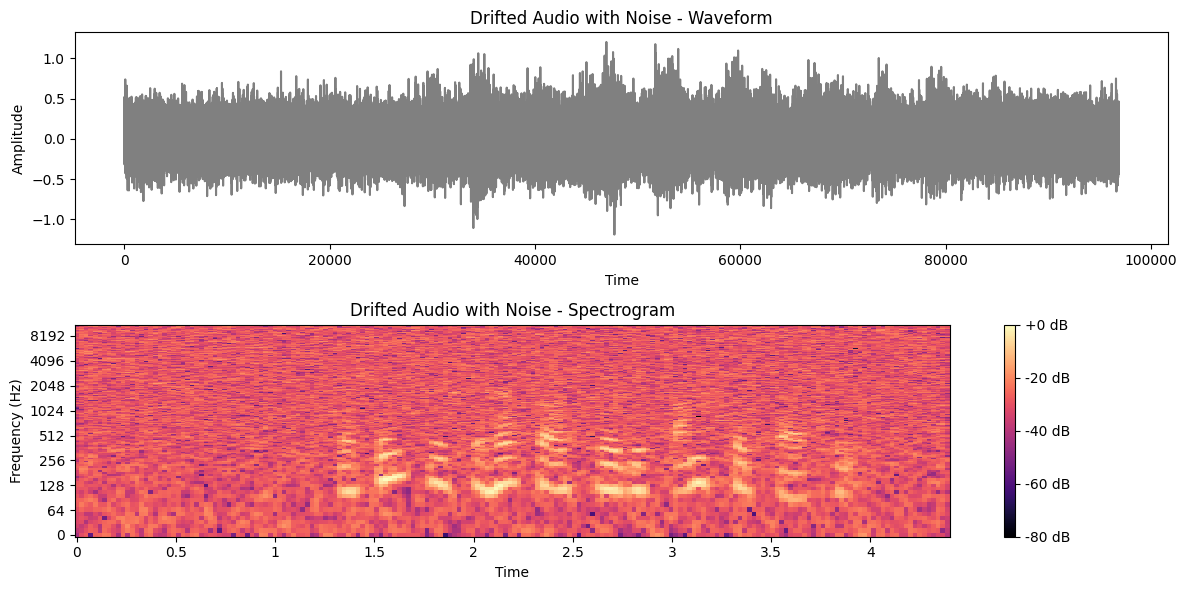

In [41]:
print("Original Audio:")
display(Audio(y_original, rate=sr_original))
plot_waveform_and_spectrogram(y_original, sr_original, "Original Audio")

print("Drifted Audio with Noise:")
display(Audio(y_drifted, rate=sr_original))
plot_waveform_and_spectrogram(y_drifted, sr_original, "Drifted Audio with Noise")


In [42]:
reference_data

mfcc_0      mfcc_1     mfcc_2     mfcc_3  spectral_centroid  \
0 -375.586090   55.341087  -8.722851  30.610806        2654.539757   
1 -396.351868   52.695805 -21.070202  20.816500        3114.218304   
2 -336.141724  130.837982   9.670650  24.370266        1437.190155   
3 -428.547272   91.421928  11.168317  -2.392702        1632.461788   
4 -499.563110   34.267368  50.317398  21.646454        3509.402726   

   spectral_contrast  zero_crossing_rate  
0          22.689431            0.220715  
1          23.326331            0.231816  
2          23.534440            0.060971  
3          25.013795            0.086317  
4          23.060417            0.210761

In [43]:
current_data_drifted

mfcc_0    mfcc_1    mfcc_2    mfcc_3  spectral_centroid  \
0  51.996874  3.998571  4.874230  3.481328        5329.002541   
1  47.499730 -1.948155  0.908527  1.341874        5457.951444   
2  48.156332  0.371978  2.576734  2.014151        5438.497120   
3  50.379433  2.699512  2.589293  0.151853        5389.218617   
4  46.235866 -2.327118  0.729832  1.414503        5476.598099   

   spectral_contrast  zero_crossing_rate  
0          12.788546            0.455785  
1          12.440777            0.487499  
2          12.567934            0.474606  
3          12.567120            0.473456  
4          12.301444            0.490942

### use evidently ai to analyze and visualize the differences between the reference dataset and the current dataset with drift.


In [46]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

# we can select the specific feature we want to use to detect drift
data_drift_report = Report(metrics=[
        DataDriftPreset(columns=['spectral_centroid', 'spectral_contrast', 'zero_crossing_rate']),     
        # DataQualityPreset()
    ])


# wun the report on reference_data (original) and current_data_drifted (corrupted)
data_drift_report.run(current_data=current_data_drifted,
                      reference_data=reference_data,
                      column_mapping=None)


data_drift_report.show()